In [0]:
#@title Copyright 2019 The Empirical Calibration Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/empirical_calibration/blob/master/notebooks/survey_calibration_cvxr.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/empirical_calibration/blob/master/notebooks/survey_calibration_cvxr.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

A common use case of surveys is to estimate the mean or total of a quantity. We
replicate the [direct standardization example](https://rviews.rstudio.com/2018/07/20/cvxr-a-direct-standardization-example/). Data
was obtained from the CVXR package's [github repo](https://github.com/anqif/CVXR/tree/master/data), where

* `dspop` contains 1000 rows with columns
   - $\text{sex} \sim \text{Bernoulli}(0.5)$
   - $\text{age} \sim \text{Uniform}(10, 60)$
   - $y_i \sim N(5 \times \text{sex}_i + 0.1 \times \text{age}_i, 1)$.
* `dssamp` contains a skewed sample of 100 rows with small
values of $y$ over-represented.

## Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_format='retina'

# install and import ec
!pip install -q git+https://github.com/google/empirical_calibration
import empirical_calibration as ec

# install and import rdata
!pip install -q rdata
import rdata

## Download data

In [0]:
# Read data from R package's github repo.
!wget -q https://github.com/anqif/CVXR/raw/master/data/dspop.rda
!wget -q https://github.com/anqif/CVXR/raw/master/data/dssamp.rda
dspop = rdata.conversion.convert(rdata.parser.parse_file('dspop.rda'))['dspop']
dssamp = rdata.conversion.convert(rdata.parser.parse_file('dssamp.rda'))['dssamp']

## Analysis

In [0]:
#@title Apply empirical calibration to get weights
cols = ['sex', 'age']
weights, _ = ec.maybe_exact_calibrate(
    covariates=dssamp[cols],
    target_covariates=dspop[cols],
    objective=ec.Objective.ENTROPY
)

### Estimates of mean
The true mean of $y$ based on the data generating process is 6.0.
Using the generated population of size 1000 and sample of size 100
contained in the \pkg{CVXR} package, the population mean is 6.01, but the
mean of the skewed sample is 3.76, which is a gross underestimation.
However, with empirical calibration, the weighted mean
is 5.82, which is closer to the population mean.

In [0]:
print('True mean of y: {}'.format(dspop['y'].mean()))
print('Un-weighted sampel mean: {}'.format(dssamp['y'].mean()))
print('Weighted mean: {}'.format(np.average(dssamp['y'], weights=weights)))

True mean of y: 6.009373516521697
Un-weighted sampel mean: 3.7554424512120006
Weighted mean: 5.821816581178334


### Kenel density
The kernel density plots show that the
unweighted curve is biased toward smaller values of $y$, but the weights help
recover the true density.

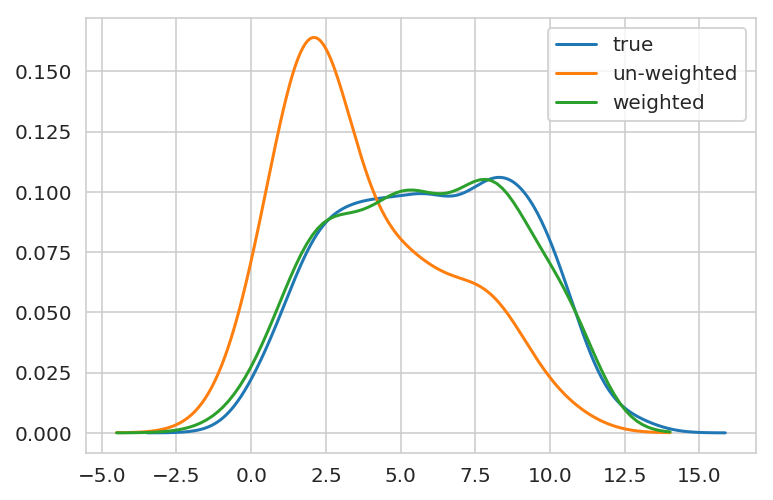

In [0]:
import statsmodels.api as sm

true = sm.nonparametric.KDEUnivariate(dspop['y'])
un_weighted = sm.nonparametric.KDEUnivariate(dssamp['y'])
weighted = sm.nonparametric.KDEUnivariate(dssamp['y'])

true.fit(bw='Scott')
un_weighted.fit(bw='Scott')
weighted.fit(fft=False, weights=weights, bw='Scott')


fig, ax = plt.subplots(1, 1)
ax.plot(true.support, true.density, label='true')
ax.plot(un_weighted.support, un_weighted.density, label='un-weighted')
ax.plot(weighted.support, weighted.density, label='weighted')
ax.legend()